In [1]:
%config Completer.use_jedi = False


In [2]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc
import os
from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [3]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [6]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/normal'#modflow model
os.chdir(wdir)

In [7]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])  # WA

csds_means = np.array([[0.120, 0.174, 0.112, 0.155, 0.066, 0.079],
                       [0.247, 0.333, 0.292, 0.212, 0.090, 0.127],
                       [0.309, 0.330, 0.244, 0.223, 0.120, 0.122],
                       [0.244, 0.269, 0.222, 0.251, 0.059, 0.107],
                       [0.220, 0.227, 0.160, 0.153, 0.078, 0.075],
                       [0.342, 0.385, 0.241, 0.481, 0.001, 0.130]])

csds_stds = np.array([[0.359, 0.356, 0.455, 0.399, 0.328, 0.452],
                      [0.986, 0.640, 0.497, 0.889, 0.275, 0.502],
                      [0.823, 0.683, 0.817, 0.819, 0.554, 0.782],
                      [0.312, 0.450, 0.444, 0.262, 0.378, 0.313],
                      [0.472, 0.415, 0.344, 0.363, 0.315, 0.599],
                      [0.542, 0.478, 0.386, 0.467, 0.001, 0.494]])




In [8]:
def plutonname(i):
    if i == 0:
        return 'AZ'
    elif i == 1:
        return 'CA_EW'
    elif i == 2:
        return 'CA_NS'
    elif i == 3:
        return 'GR'
    elif i == 4:
        return 'MT'
    elif i == 5: 
        return 'WA'

In [9]:
def lineplotpcgmcg(pluton, sedgenmech, name):
    fig, ax = plt.subplots()
    ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
    ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)

    ax.text(70, 12, "mcg", color=sns.color_palette()[1], fontsize=12)
    ax.text(70, 2.5, "pcg", color=sns.color_palette()[0], fontsize=12)

    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.set_xlim(0, 77)
    ax.spines['bottom'].set_bounds(0, 77)
    ax.spines['left'].set_bounds(0, 14)
    ax.spines['left'].set_position(('outward', 10))
    # Set general tick parameters
    ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)
    ax.set_title('pcg,mcg'+ pluton)
    ax.set_xlabel("Timesteps", color='grey')
    ax.set_ylabel("$\log_{10}$n", rotation=0, labelpad=20, color='grey')
    # Set facecolor of figure
    plt.gcf().set_facecolor('white')
    sns.despine()
    # plt.legend()
    plt.tight_layout()
    plt.savefig('lineplot_pcgmcg_evolution_chem+mech' +name+ pluton +'.png')
    plt.show()

In [10]:
def lineplotchemweath(pluton, sedgenchem, sedgen, name):
    fig, ax = plt.subplots() 

    for i in range(6):
        ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
    
    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(0, 100)
    ax.set_ylim(4.5, 8.5)

    ax.spines['bottom'].set_bounds(0, 100)
    ax.spines['left'].set_bounds(4.5, 8.5)

    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 5))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)

    ax.set_xlabel("Timesteps", color='grey')
    ax.set_ylabel("$\log_{10}$V", rotation=0, labelpad=20, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("lineplot_volume_residue_chem+mech"+name+pluton+".png")
    plt.show();


In [11]:
def barplotvolumepergrainsize(pluton, sedgenweath, name):
    fig, ax = plt.subplots()

    for d in range(0, 1500, 25):
        heights = np.zeros(6)
        for m in range(6):
            csd_filter = sedgenweath.pcg_crystal_sizes[0][sedgenweath.pcg_crystals[0] == m]
            chem_state_filter = sedgenweath.pcg_chem_weath_states[0][sedgenweath.pcg_crystals[0] == m]

            csd_filter_filtered = csd_filter[np.where((d <= csd_filter) & (csd_filter < d+25))]
            chem_state_filter_filtered = chem_state_filter[np.where((d <= csd_filter) & (csd_filter < d+25))]
            heights[m] = np.sum(sedgenweath.volume_bins_medians_matrix[chem_state_filter_filtered, 0, csd_filter_filtered])
            if d == 600:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
            else:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)

    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(-10, 5)
    ax.set_ylim(0, 2e7)

    ax.spines['bottom'].set_bounds(-10, 5)
    ax.spines['left'].set_bounds(0, 2e7)

    ax.spines['left'].set_position(('outward', 10))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)

    ax.set_xlabel("Phi-scale", color='grey')
    ax.set_ylabel("V", rotation=0, labelpad=20, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("barplot_volume_pcg_xx_"+name+pluton+".png")
    plt.show();

In [12]:
def barplotvolume(pluton, sedgenweath, name):
    fig, ax = plt.subplots()

    for d in range(0, 1500, 25):
        heights = np.sum(sedgenweath.mcg[0, :, d:d+25] * sedgenweath.volume_bins_medians_matrix[0, :, d:d+25], axis=1)
        if d == 750:
            print(heights)
        for m in range(6):
            if d == 600:
                ax.bar(np.log2(sedgenweath.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
            else:
                ax.bar(np.log2(sedgenweath.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])


    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(-10, 5)
    ax.set_ylim(0, 2e7)

    ax.spines['bottom'].set_bounds(-10, 5)
    ax.spines['left'].set_bounds(0, 2e7)

    ax.spines['left'].set_position(('outward', 10))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)

    ax.set_xlabel("Phi-scale", color='grey')
    ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("barplot_volume_mcg_mech_CA-NS" + name + pluton + ".png")
    plt.show();
    

In [13]:
def barplotvolumebothoper(pluton, sedgenweath, name):
    fig, ax = plt.subplots()

    for d in range(0, 1500, 25):
        heights = np.sum(np.sum(sedgenweath.mcg[:, :, d:d+25] * sedgenweath.volume_bins_medians_matrix[:, :, d:d+25], axis=0), axis=1)
        for m in range(6):
            if d == 600:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
            else:
                ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)


    # Set the color of the visible spines
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')

    ax.set_xlim(-10, 5)
    ax.set_ylim(0, 1e7)

    ax.spines['bottom'].set_bounds(-10, 5)
    ax.spines['left'].set_bounds(0, 1e7)

    ax.spines['left'].set_position(('outward', 10))

    # Set general tick parameters
    ax.tick_params(axis='both',
                   direction='out',
                   colors='grey',
                   labelsize=9)

    ax.set_xlabel("Phi-scale", color='grey')
    ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

    ax.set_xticklabels(list(range(10, -6, -2)))

    # Set facecolor of figure
    plt.gcf().set_facecolor('white')

    sns.despine()

    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.savefig("barplot_volume_mcg_both_CA-NS" + name + pluton + ".png")
    plt.show();

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 86 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


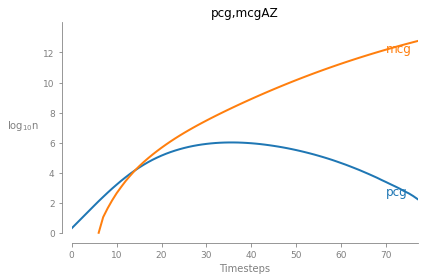

[ 575681.29559083 2169415.38830082  643194.06450702  287439.9346238
   55008.2550034   788556.02755527]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


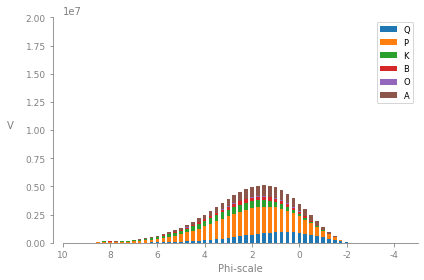

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

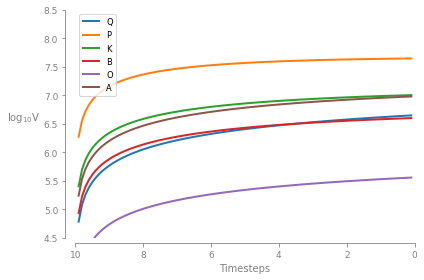

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


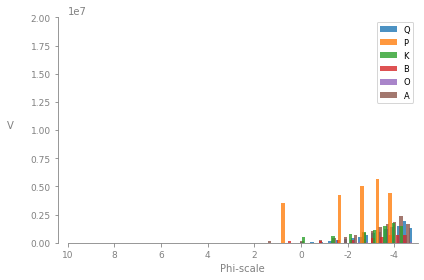

After 67 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


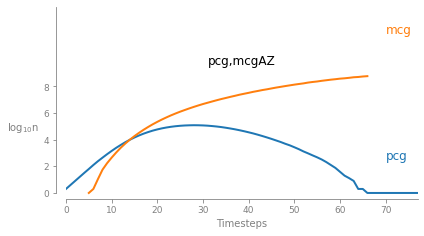

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

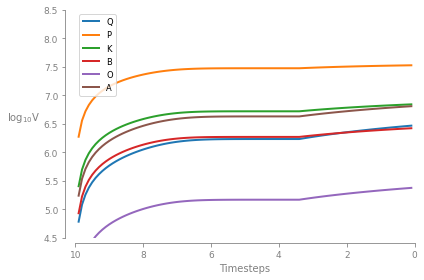

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


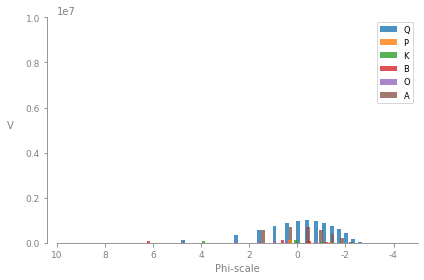

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
too few P -2
too few K -2
too few B -1
too few O -3
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 72 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


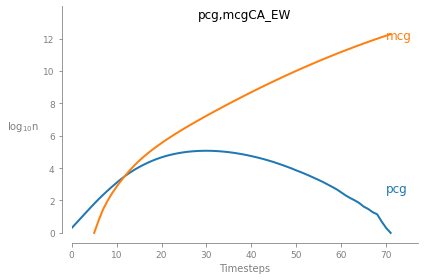

[ 275120.05911638 1126872.16789151 1031409.7516941   359504.38504331
   19987.1496215   138426.57870186]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


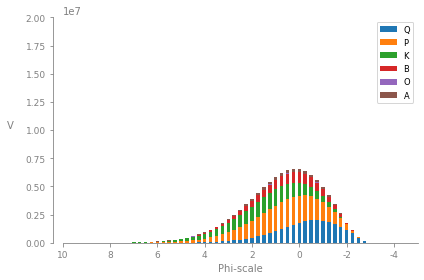

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

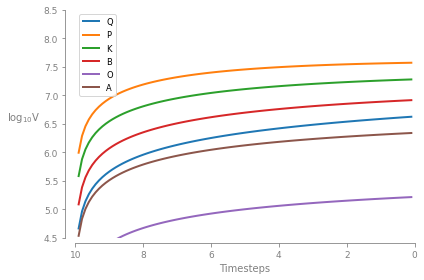

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


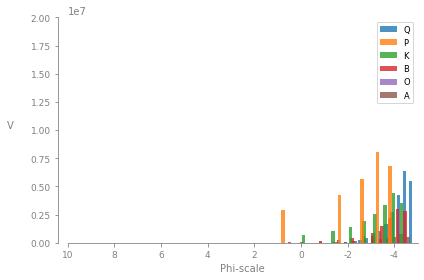

After 54 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


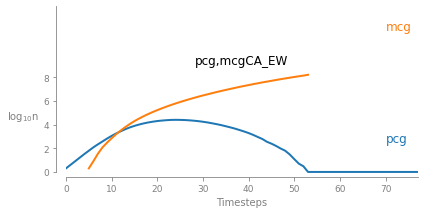

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

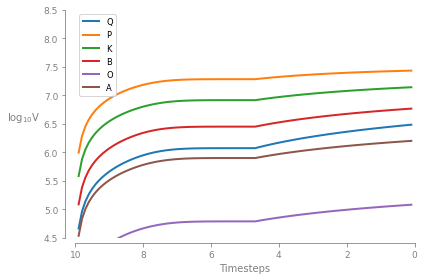

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


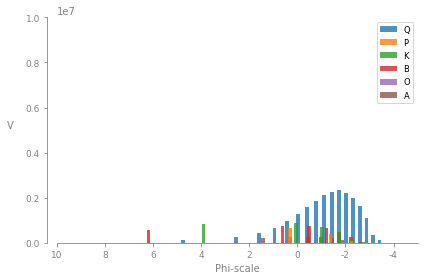

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 69 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


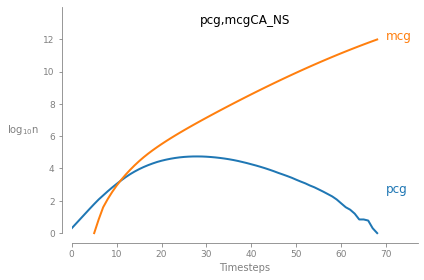

[269918.54293563 965506.26974784 952791.96827733 288902.44727772
  41080.73596525 146284.65787944]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


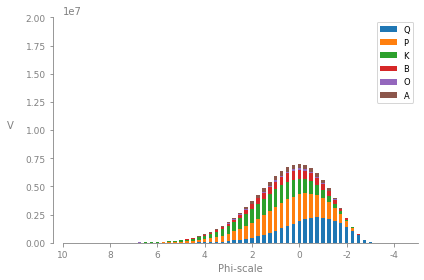

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

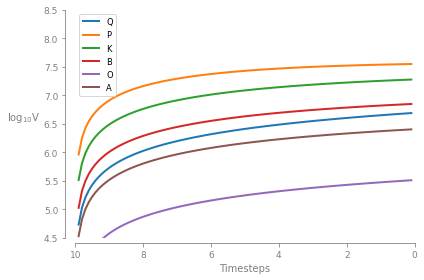

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


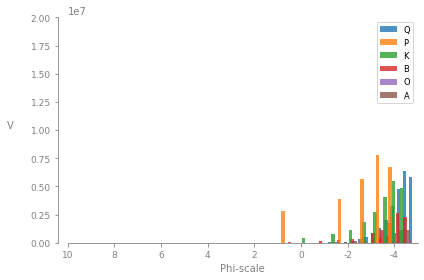

After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


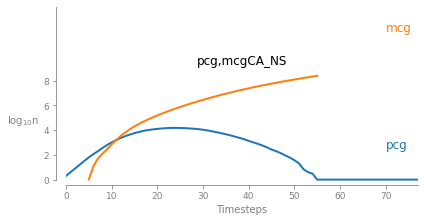

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

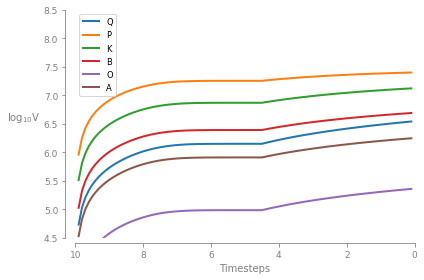

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


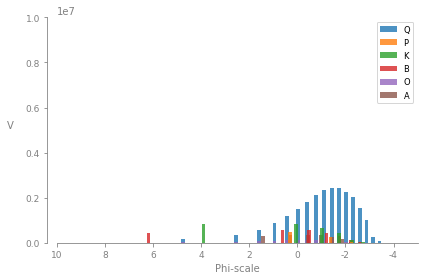

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
all good P 0
too much K 1
too few B -1
too few O -3
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 89 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


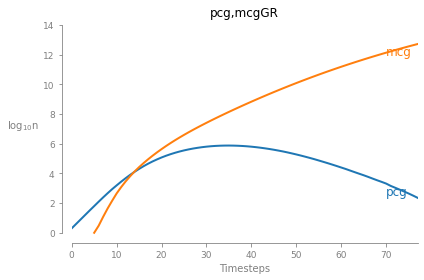

[ 796365.54563015 2079360.93276928  797997.53163764  335702.9163968
   50935.46692333  736995.13011036]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


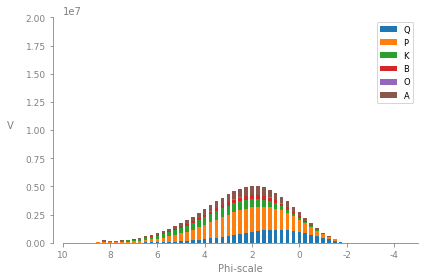

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

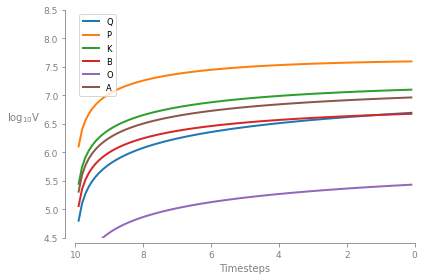

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


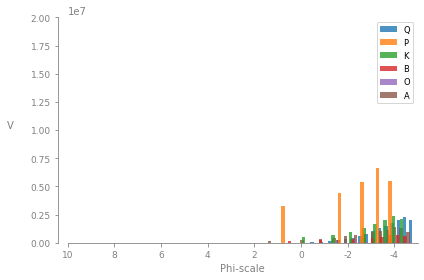

After 65 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


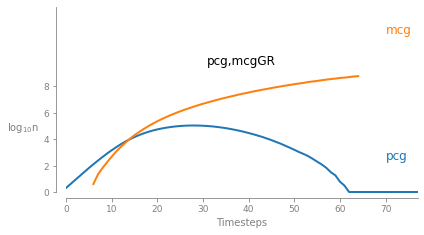

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

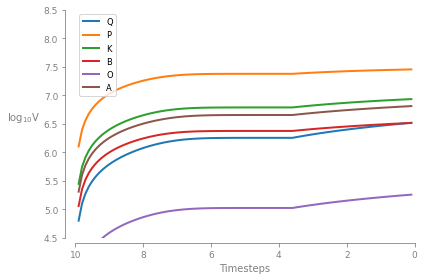

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


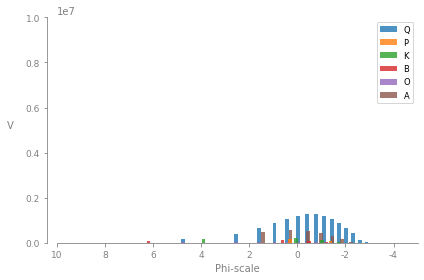

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 25
too few P -7
too few K -8
too few B -3
too few O -4
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 79 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


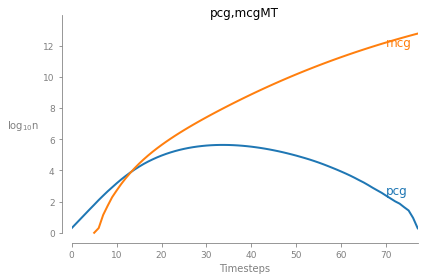

[ 497270.20130193 1755820.21318636  762540.84757123  187101.625975
   30227.5359525   236891.47237899]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


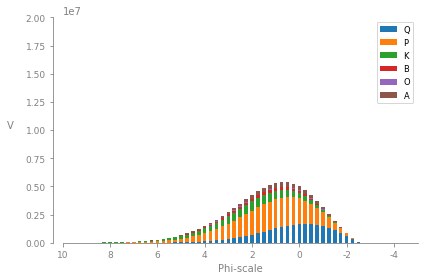

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

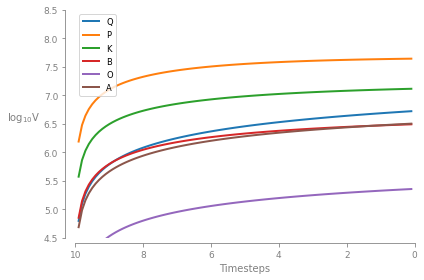

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


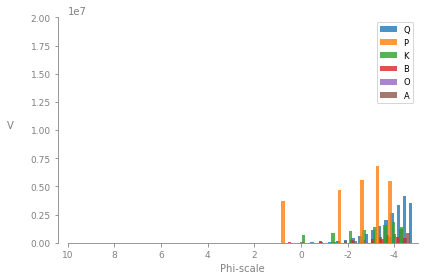

After 64 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


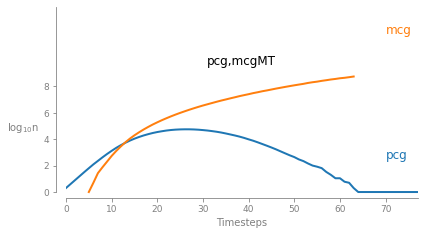

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

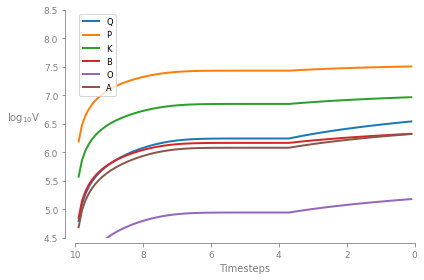

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


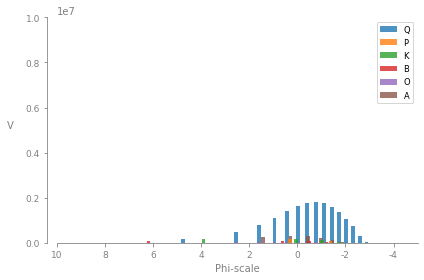

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 3
all good P 0
all good K 0
all good B 0
too few O -2
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 79 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


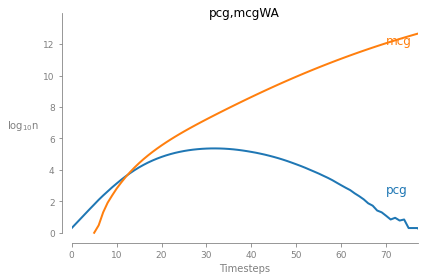

[ 491826.17161514 2041957.28357814  307895.91871889  502992.8222691
       0.          476128.73244267]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


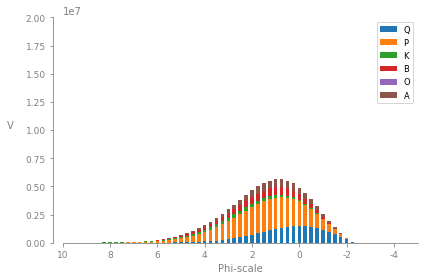

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

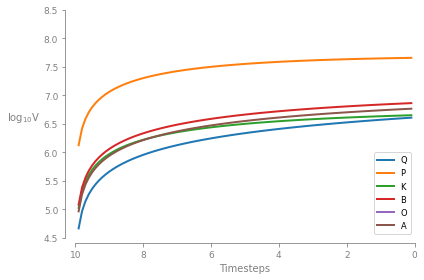

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


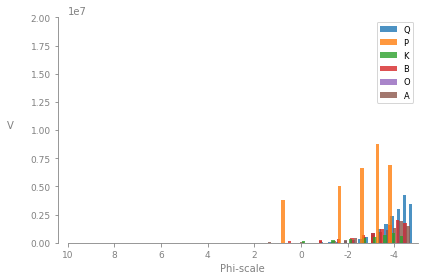

After 61 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


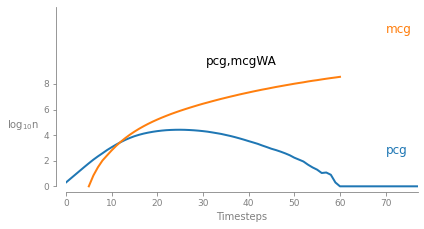

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

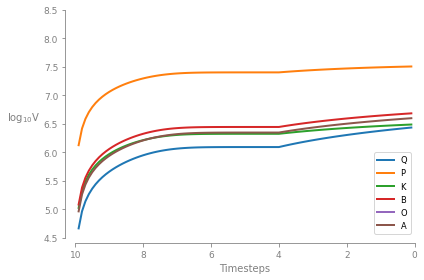

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


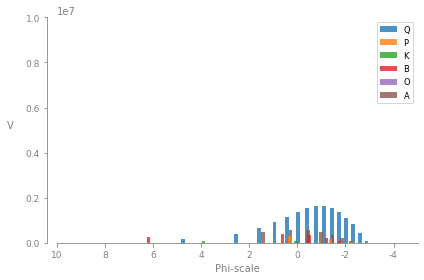

Wall time: 22min 12s


In [14]:
%%time
for i in range (6): #voor alle plutons
#for i in ([2]): #testen bij slechts 1 pluton  
    #sedgen running for every pluton
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], csds_means[i], csds_stds[i],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03])
        #establishing plutonname
    pluton = plutonname(i)
    
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech")
    barplotvolume(pluton, sedgen_mech, "sedgen_mech")
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem")
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem")

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech")
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech")
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech")
    

In [18]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/new_input'#modflow model
os.chdir(wdir)

In [20]:
# Create scenario data
balance = np.array([0] * 100)
climate = np.array([2] * 100)
# Keep additional input material limited to first couple of steps
# Otherwise this has a massive performance impact regarding the time it
# takes for the model to execute due to very high number of pcgs/mcgs.
new_input = np.array([0.01] * 10 + [0.0] * 90)

scenario_array = np.stack([balance, climate, new_input], axis=1)



---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 86 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


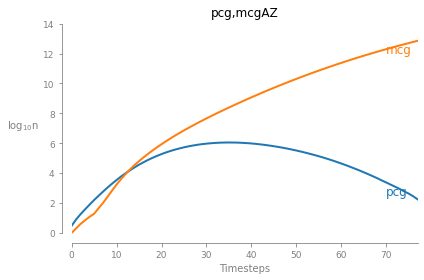

[ 644635.7919381  2387974.9760826   699247.61365211  316843.36184589
   61948.06838978  866645.34299748]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


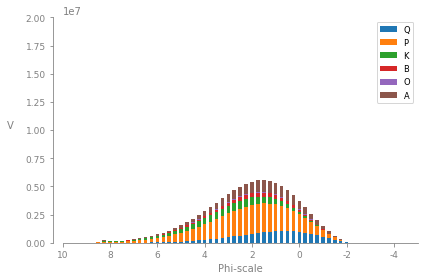

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

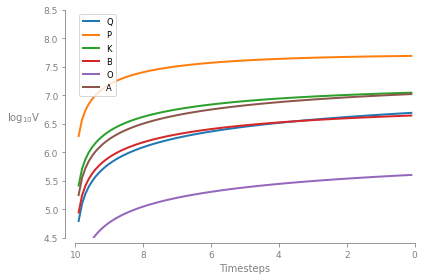

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


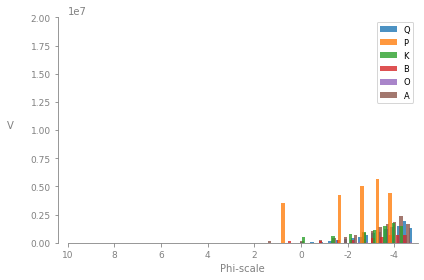

After 67 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


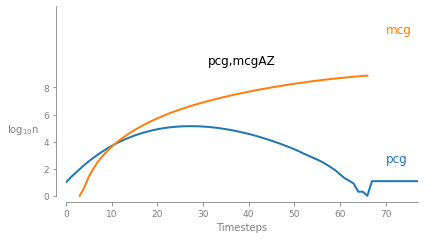

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

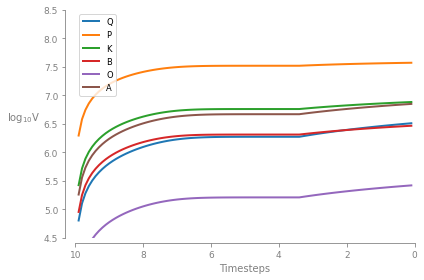

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))
C:\Users\quint\anaconda3\envs\sedgen\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


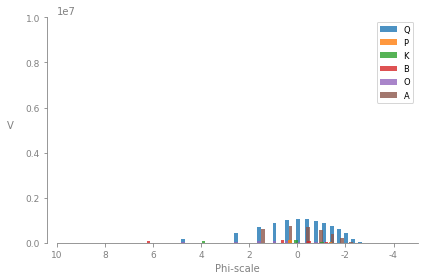

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
too few P -2
too few K -2
too few B -1
too few O -3
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 72 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


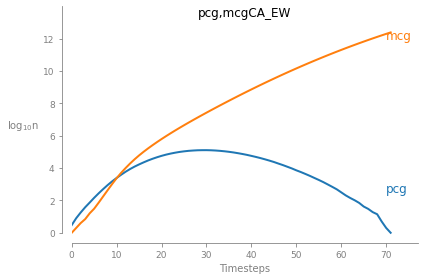

[ 323963.08767043 1283513.40589396 1153422.24457968  410595.50273514
   22464.93975974  157393.59424956]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


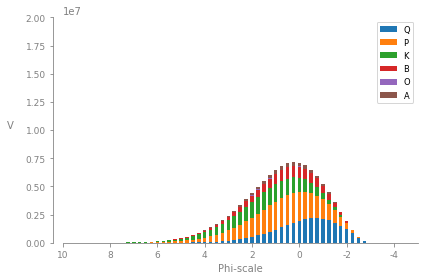

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

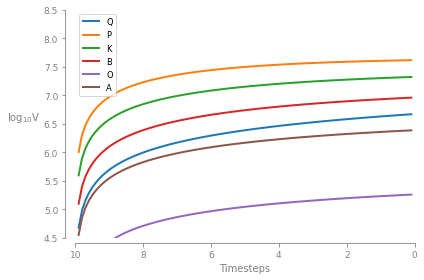

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


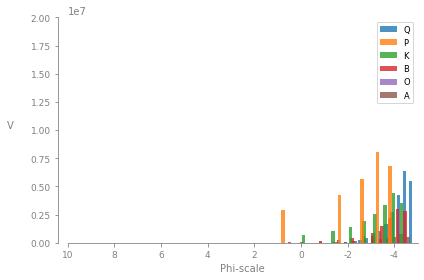

After 54 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


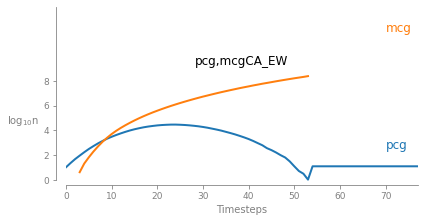

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

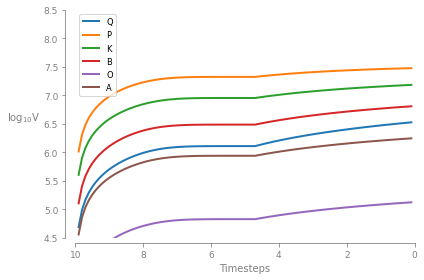

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


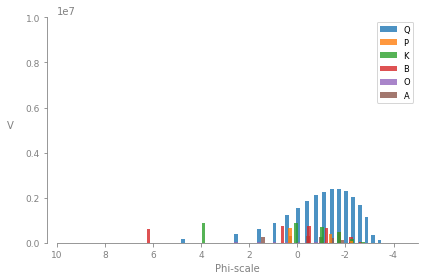

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 69 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


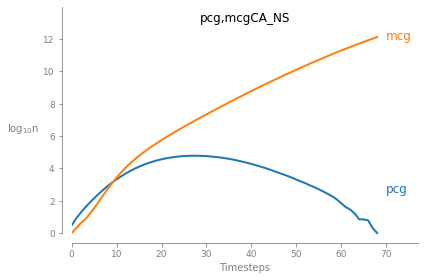

[ 319614.88637092 1111146.52180388 1091890.48650051  331823.84454863
   47579.26634322  168573.87890754]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


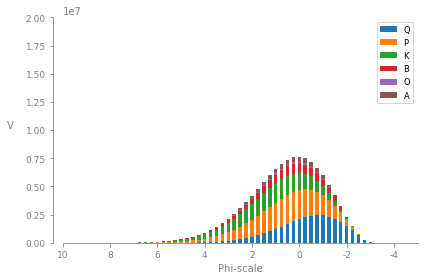

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

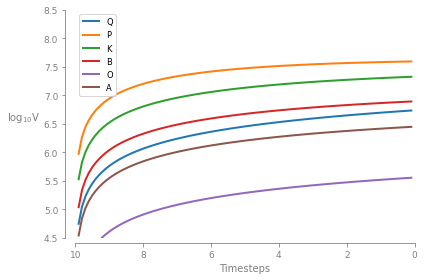

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


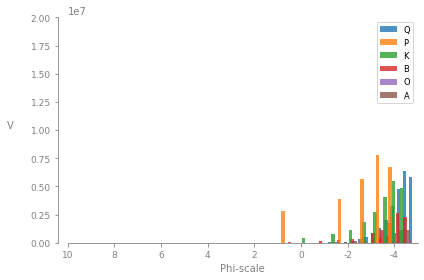

After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


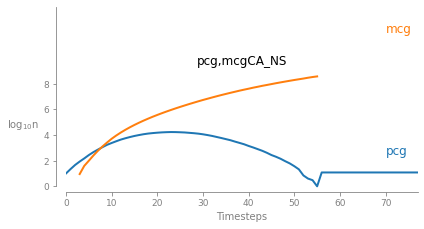

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

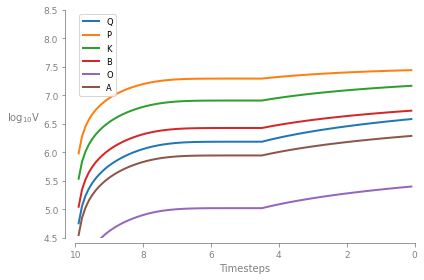

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


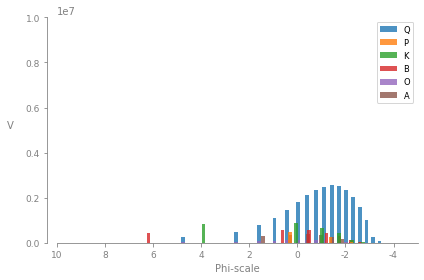

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 9
all good P 0
too much K 1
too few B -1
too few O -3
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 89 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


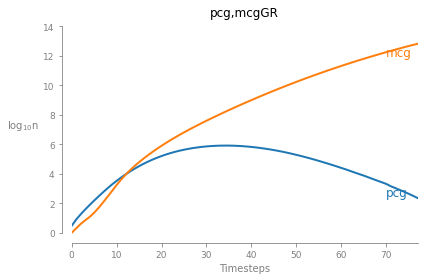

[ 885416.44370667 2292226.99595826  865769.57559963  370065.00650547
   57364.06346061  806610.22531296]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


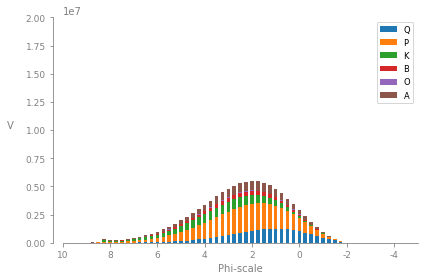

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

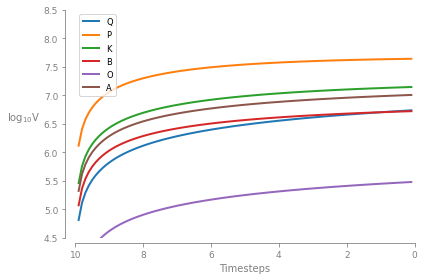

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


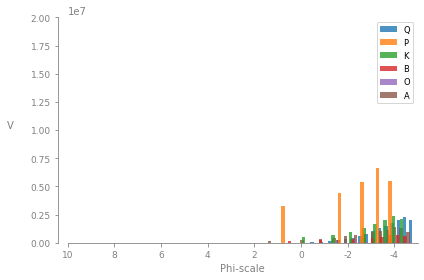

After 65 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


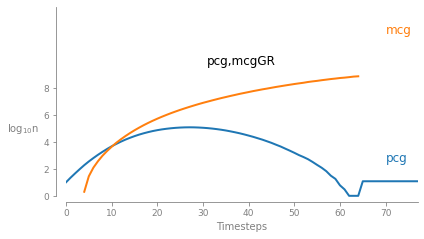

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

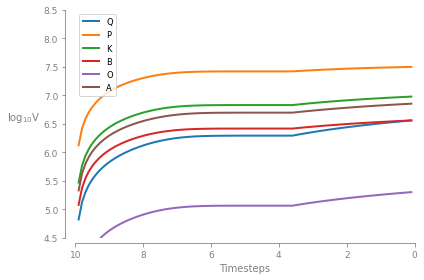

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


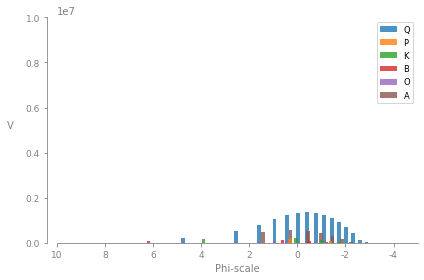

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 25
too few P -7
too few K -8
too few B -3
too few O -4
too few A -3
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 79 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


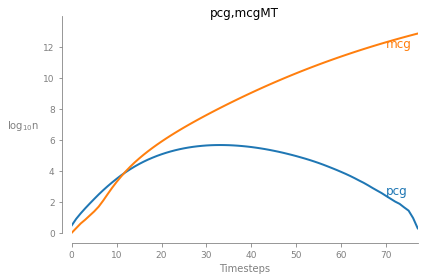

[ 565039.70743798 1970980.84924284  835518.43127816  209404.04959769
   34251.26905132  265177.28053988]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


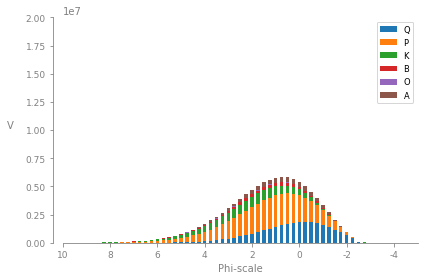

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

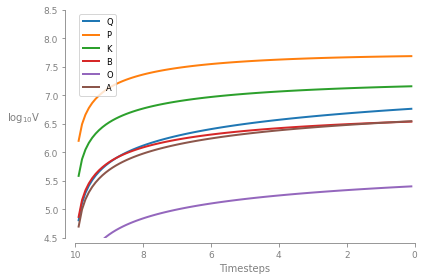

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


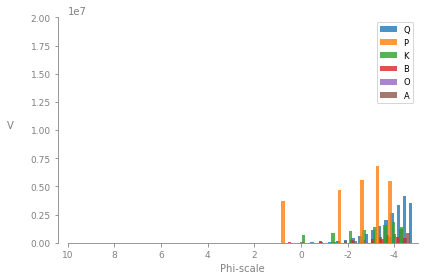

After 64 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


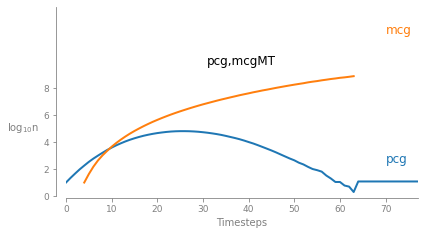

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

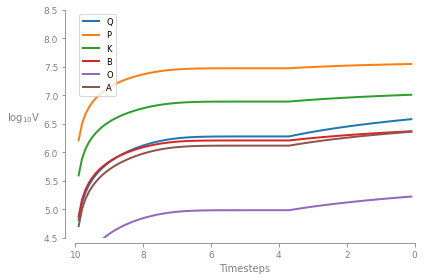

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


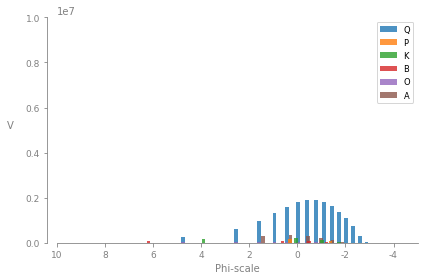

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 3
all good P 0
all good K 0
all good B 0
too few O -2
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 79 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


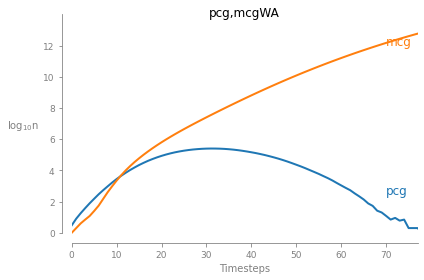

[ 566782.5495457  2284882.45617899  335536.7624793   556996.34498924
       0.          532348.55181722]


<ipython-input-12-040ca29b0a79>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


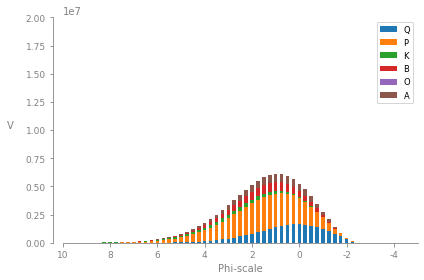

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

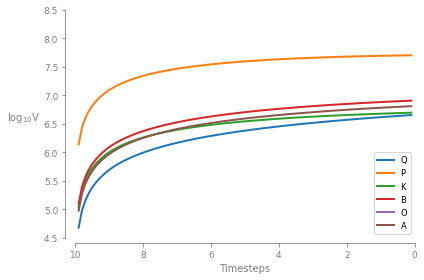

<ipython-input-11-b80e6f6d2ca9>:16: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:14: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-11-b80e6f6d2ca9>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


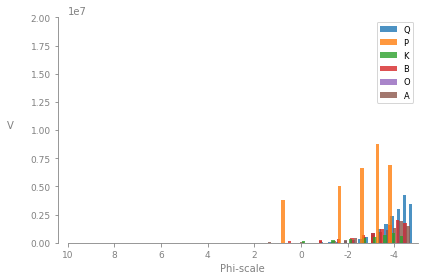

After 61 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


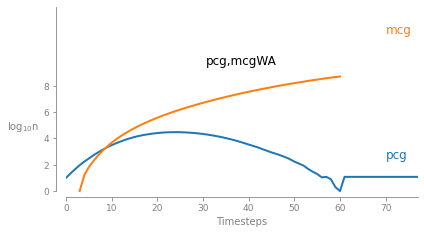

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

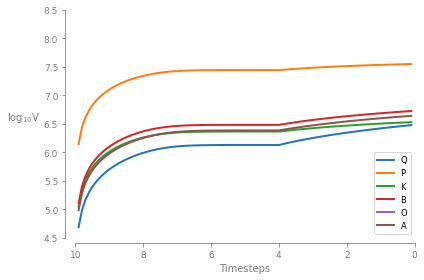

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


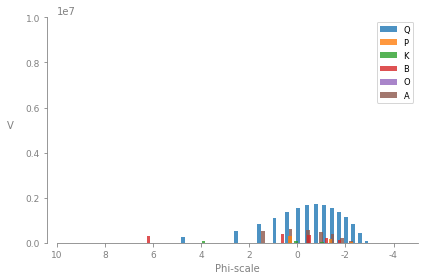

Wall time: 26min 40s


In [21]:
%%time
for i in range (6): #voor alle plutons
#for i in ([2]): #testen bij slechts 1 pluton  
    #sedgen running for every pluton
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[i], csds_means[i], csds_stds[i],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    scenario_data = scenario_array)
        #establishing plutonname
    pluton = plutonname(i)
    name_addition = "new_input"
    
        #running mechanical weathering
    sedgen_mech = sedgen.weathering(operations = ["intra_cb","inter_cb"], timesteps = 100, inplace = False) 
        #plotting
    lineplotpcgmcg(pluton,sedgen_mech, "sedgen_mech" + name_addition)
    barplotvolume(pluton, sedgen_mech, "sedgen_mech" + name_addition)
    
        #running chemical weathering
    sedgen_chem = sedgen.weathering(operations = ["chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
        #plotting
    lineplotchemweath(pluton, sedgen_chem, sedgen, "sedgen_chem" + name_addition)
    barplotvolumepergrainsize(pluton, sedgen_chem, "sedgen_chem" + name_addition)

        #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)

Now investigate balance between mechanical and chemical weathering using scenario_data as input
use of CA_NS pluton


In [29]:
wdir = r'D:/unif/masterthesis/jupyter/sedgenmasterthesisQ/figures/simulation/balance'#modflow model
os.chdir(wdir)

In [30]:
# Create scenario data
def createscenariodata(balans,climate,newinput):
    balance = np.array([balans] * 100)
    climate = np.array([climate] * 100)
    # Keep additional input material limited to first couple of steps
    # Otherwise this has a massive performance impact regarding the time it
    # takes for the model to execute due to very high number of pcgs/mcgs.
    new_input = np.array([newinput] * 10 + [0.0] * 90)

    scenario_array = np.stack([balance, climate, new_input], axis=1)
    return scenario_array

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


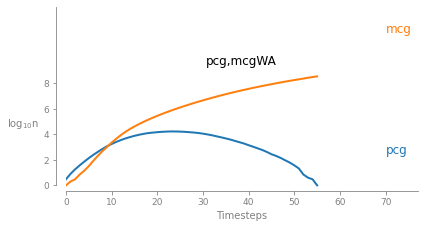

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

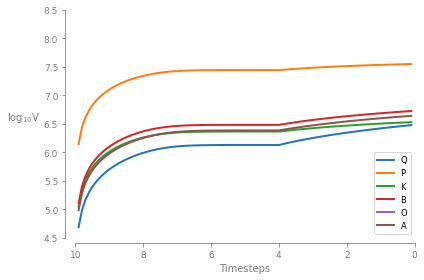

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


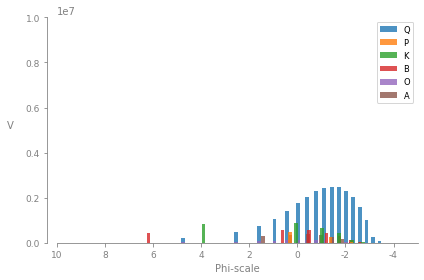

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


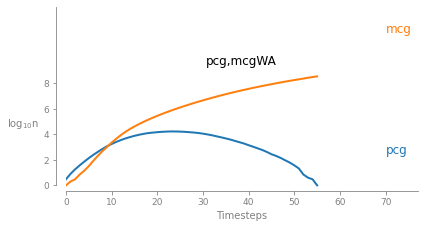

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

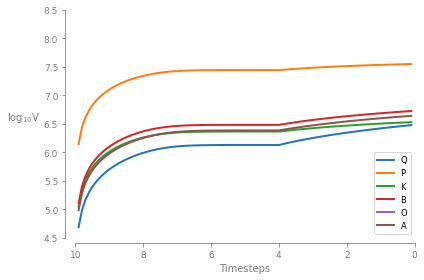

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


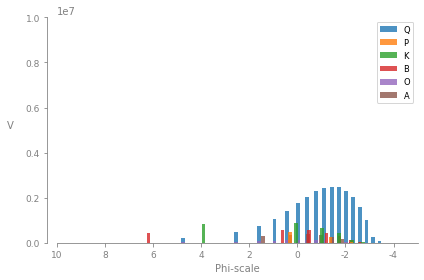

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


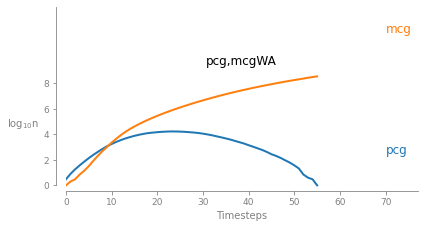

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

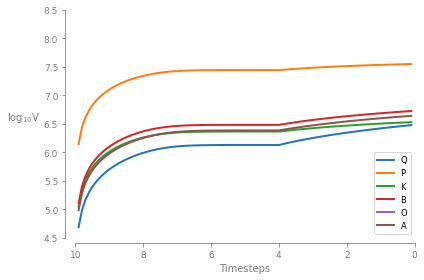

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


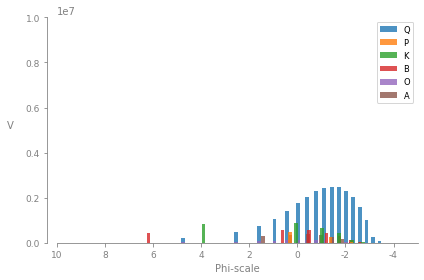

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


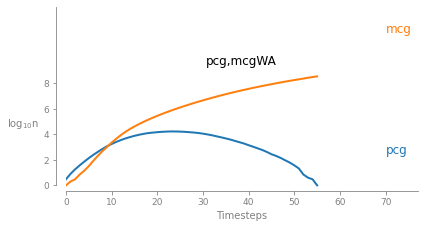

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

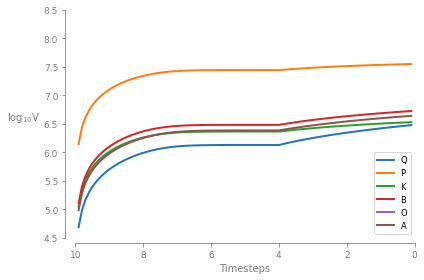

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


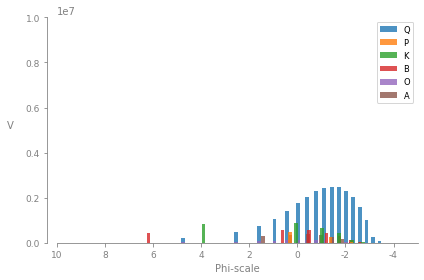

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


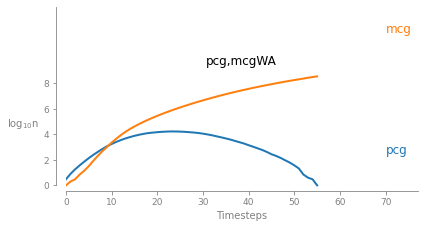

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

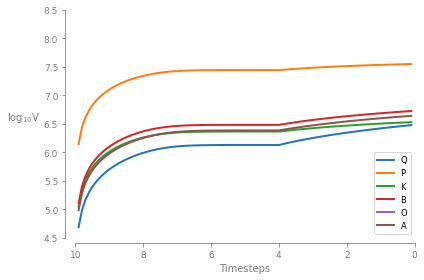

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


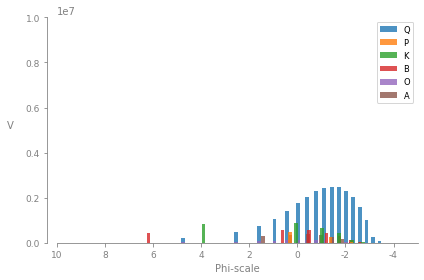

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


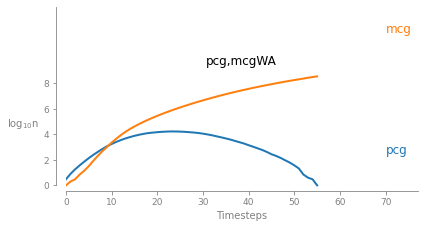

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

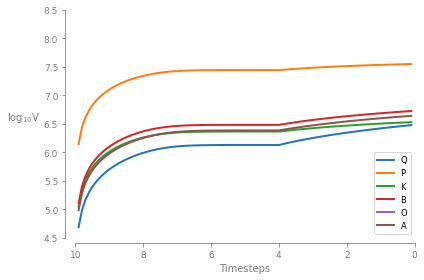

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


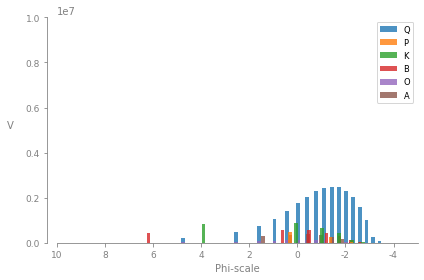

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


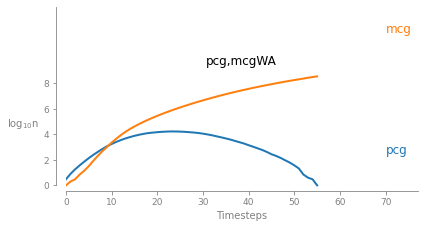

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

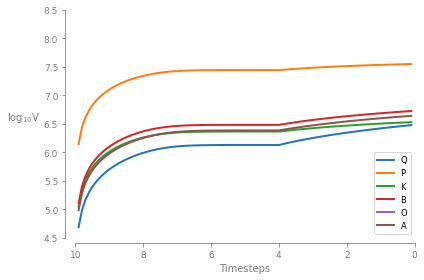

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


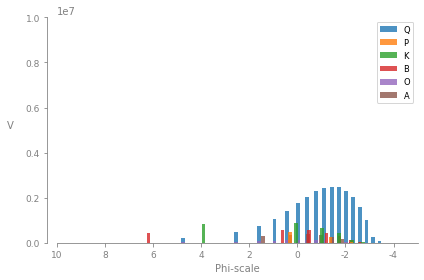

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


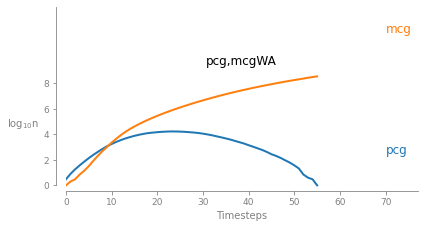

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

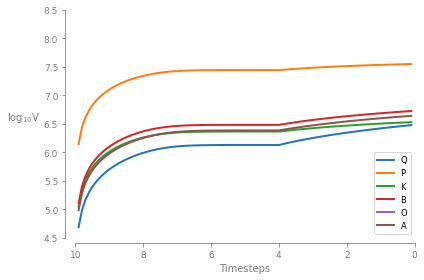

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


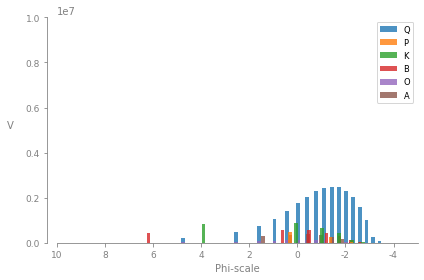

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


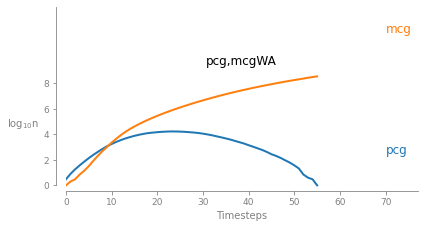

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

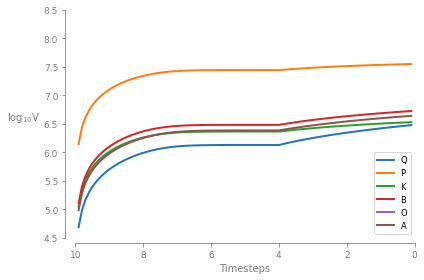

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


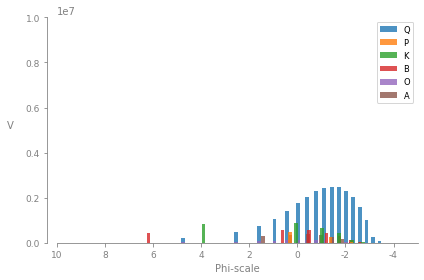

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


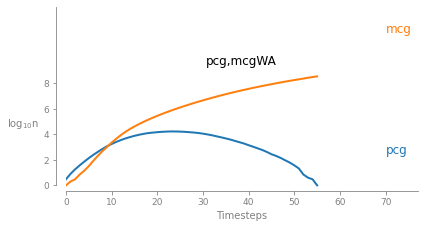

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

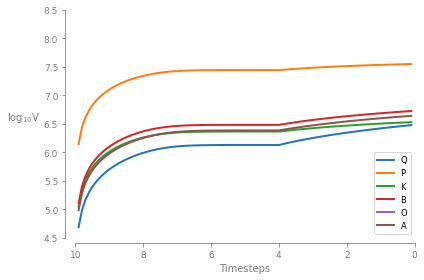

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


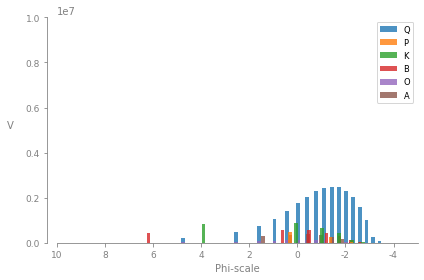

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A|
Initializing interfaces... |Q|P|K|B|O|A|
Counting interfaces...
Correcting interface arrays for consistency...
too much Q 2
too few P -1
too few K -1
all good B 0
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A|
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
After 56 steps all pcgs have been broken down to mcg


<ipython-input-9-3fdf600551de>:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.pcg_additions), label="pcg", lw=2)
<ipython-input-9-3fdf600551de>:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


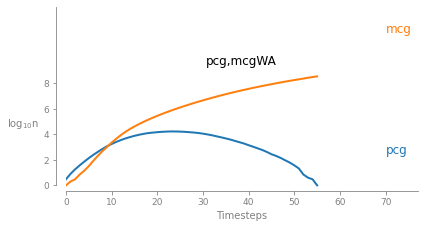

<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-input-10-9a983608de2e>:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(np.cumsum(sedgen_chem.pcg_chem_residue_additions[:,i])), label=sedgen.pr_minerals[i], lw=2)
<ipython-i

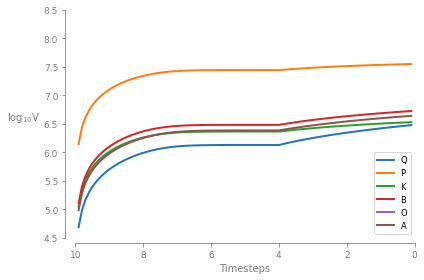

<ipython-input-13-04b2273cfa95>:10: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:8: RuntimeWarning: invalid value encountered in log2
  ax.bar(np.log2(sedgenweath.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
<ipython-input-13-04b2273cfa95>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(range(10, -6, -2)))


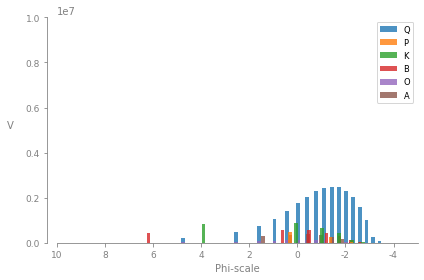

In [31]:
balanslist = np.arange(0, 1.1, 0.1, dtype = float)
print(balanslist)
climate = 2
newinput = 0.01
for i in balanslist:
    balance = i
    scenario_array = createscenariodata(balance, climate, newinput)
    #model
    sedgen = SedGen(minerals, 1e8, modal_mineralogy[2], csds_means[2], csds_stds[2],
                    learning_rate = 1000,
                    chem_weath_rates = [0.01, 0.13, 0.07, 0.05, 0.01, 0.03],
                    scenario_data = scenario_array)
    
    #running chemical mechanical weathering
    sedgen_chem_mech = sedgen.weathering(operations = ["intra_cb","inter_cb","chem_mcg","chem_pcg"],timesteps = 100, inplace = False)
    balancename = str(i)
    name_addition = "balance" + balancename
    lineplotpcgmcg(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)
    lineplotchemweath(pluton, sedgen_chem_mech, sedgen, "sedgen_chem_mech" + name_addition)
    barplotvolumebothoper(pluton, sedgen_chem_mech, "sedgen_chem_mech" + name_addition)

    